[View in Colaboratory](https://colab.research.google.com/github/Joovvhan/Master-Thesis/blob/master/log/A3F1P3-A3F5P3_ResNet50.ipynb)

In [1]:
# Import necessary modules

import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wf
import time
import glob
import datetime

from tqdm import trange

# Import Keras modules

from keras.preprocessing import image
from keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras import backend as K
from keras.models import load_model


Using TensorFlow backend.


In [0]:
# Mount google drive

# from google.colab import drive
# drive.mount('/content/gdrive')
# os.listdir('gdrive/My Drive/Colab')

In [0]:
# Set data directories

# dataPath = 'gdrive/My Drive/Colab/Data'
dataPath = '''D:\\0_Joowhan's Paper\\Synthesized\\Total'''
modelPath = '''D:/0_Joowhan's Paper/Synthesized/Total/Model'''

# Changed variable names to normal and fault
# Changed variable names from folder to path
# Need to consider multiple folders
# Need to add files to be tested

# folderNormal = 'A3F1P3'
# folderFault = 'A3F5P3'

folderNormal = 'A3F1P3'
folderFault = 'A3F5P3'


pathNormal = dataPath + '/' + folderNormal
pathFault = dataPath + '/' + folderFault

filesNormal = os.listdir(pathNormal)
filesNormal = [file for file in filesNormal if file.endswith('.wav')]

filesFault = os.listdir(pathFault)
filesFault = [file for file in filesFault if file.endswith('.wav')]

In [0]:
# Specgram settings

nsc = 1470
nov = nsc/2
nff = nsc 
imgSize = 224

pretrainedModel = 'VGG19'
pretrainedModel = 'Xception'
pretrainedModel = 'ResNet50'
lastActivation = 'softmax'
sizeBatch = 2
numEpochs = 8
verb = 1


# Learning parameters

trainingRatio = 0.8

In [5]:
# Execution confirmed with new variable names

# Check whether npy file exists 

npyNormalPath = glob.glob(pathNormal + '/' + '*.npy')

if (len(npyNormalPath) == 1):
    imgsNormal = np.load(npyNormalPath[0])

else:
    imgsNormal = np.zeros([len(filesNormal), imgSize, imgSize])
    
    for i in trange(len(filesNormal)):
        fs, dataInt16 = wf.read(pathNormal + '/' + filesNormal[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsNormal[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
    np.save(pathNormal + '/' + folderNormal + '.npy', imgsNormal)
        
print('Normal Image Shape: {}'.format(imgsNormal.shape))

Normal Image Shape: (1000, 224, 224)


In [6]:
# Execution confined with new varible names

# Check whether npy file exists

npyFaultPath = glob.glob(pathFault + '/' + '*.npy')

if (len(npyFaultPath) == 1):
    imgsFault = np.load(npyFaultPath[0])

else:
    imgsFault = np.zeros([len(filesFault), imgSize, imgSize])

    for i in trange(len(filesFault)):
        fs, dataInt16 = wf.read(pathFault + '/' + filesFault[i])
        dataFloat = dataInt16 / (2 ** 15)
        Pxx, _, _, _ = plt.specgram(dataFloat, NFFT=nff, Fs=fs, noverlap=nov, \
                                           window=np.hamming(nsc), cmap='viridis')
        plt.close()
        imgsFault[i, :, :] = 10 * np.log10(Pxx[0:imgSize, :])
        
    np.save(pathFault + '/' + folderFault + '.npy', imgsFault)
        
print('Fault Image Shape: {}'.format(imgsFault.shape))

Fault Image Shape: (1000, 224, 224)


In [7]:
# Change name from imgsF1 or imgsF5 to imgsNormal and imgsFault

dataNumNormal = len(imgsNormal)
dataNumFault = len(imgsFault)
dataNumNormalTrain = int(dataNumNormal * trainingRatio)
dataNumFaultTrain = int(dataNumFault * trainingRatio)
dataNumNormalTest = dataNumNormal - dataNumNormalTrain
dataNumFaultTest = dataNumFault - dataNumFaultTrain

print('Normal Train:Test = {:d}:{:d}'.format(dataNumNormalTrain, dataNumNormalTest))
print('Fault  Train:Test = {:d}:{:d}\n'.format(dataNumFaultTrain, dataNumFaultTest))

trainIdxNormal = np.random.choice(dataNumNormal - 1, dataNumNormalTrain, replace=False)
testIdxNormal = list(set(range(0, dataNumNormal)) - set(trainIdxNormal))

trainImgsNormal = imgsNormal[trainIdxNormal, :, :]
testImgsNormal = imgsNormal[testIdxNormal, :, :]

print('Normal Training Image Shape {}'.format(trainImgsNormal.shape))
print('Normal Test Image Shape {}\n'.format(testImgsNormal.shape))

trainIdxFault  = np.random.choice(dataNumFault - 1, dataNumFaultTrain, replace=False)
testIdxFault = list(set(range(0, dataNumFault)) - set(trainIdxFault))

trainImgsFault = imgsFault[trainIdxFault, :, :]
testImgsFault = imgsFault[testIdxFault, :, :]

print('Fault Training Image Shape {}'.format(trainImgsFault.shape))
print('Fault Test Image Shape {}\n'.format(testImgsFault.shape))

trainImgs = np.vstack([trainImgsNormal, trainImgsFault])
testImgs = np.vstack([testImgsNormal, testImgsFault])

print('Training Image Shape {}'.format(trainImgs.shape))
print('Test Image Shape {}'.format(testImgs.shape))

Normal Train:Test = 800:200
Fault  Train:Test = 800:200

Normal Training Image Shape (800, 224, 224)
Normal Test Image Shape (200, 224, 224)

Fault Training Image Shape (800, 224, 224)
Fault Test Image Shape (200, 224, 224)

Training Image Shape (1600, 224, 224)
Test Image Shape (400, 224, 224)


In [8]:
trainMean = np.mean(trainImgs)
trainStd = np.std(trainImgs)

print('Mean of Training Image: {}'.format(trainMean))
print('Standard Deviation of Training Image: {}'.format(trainStd))

Mean of Training Image: -78.09932207346547
Standard Deviation of Training Image: 9.388218064976726


In [0]:
# Should Change Norm to Normalized

trainImgsNorm = (trainImgs - trainMean) / trainStd
testImgsNorm = (testImgs - trainMean) / trainStd

trainImgsNorm = trainImgsNorm.reshape(list(trainImgsNorm.shape) + [1])
testImgsNorm = testImgsNorm.reshape(list(testImgsNorm.shape) + [1])

In [10]:
X_train = np.stack([trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0], trainImgsNorm[:, :, :, 0]], axis = -1)
X_test = np.stack([testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0], testImgsNorm[:, :, :, 0]], axis = -1)

print('X_train Shape: {}'.format(X_train.shape))
print('X_test  Shape: {}'.format(X_test.shape))

X_train Shape: (1600, 224, 224, 3)
X_test  Shape: (400, 224, 224, 3)


In [11]:
trainLabelNormal = np.stack((np.ones(dataNumNormalTrain), np.zeros(dataNumNormalTrain)), axis = -1)
testLabelNormal = np.stack((np.ones(dataNumNormalTest), np.zeros(dataNumNormalTest)), axis = -1)

trainLabelFault = np.stack((np.zeros(dataNumFaultTrain), np.ones(dataNumFaultTrain)), axis = -1)
testLabelFault = np.stack((np.zeros(dataNumFaultTest), np.ones(dataNumFaultTest)), axis = -1)

Y_train = np.vstack((trainLabelNormal, trainLabelFault))
Y_test = np.vstack((testLabelNormal, testLabelFault))

print('Y_train Normal:Fault = {:d}:{:d}'.format(len(trainLabelNormal), len(trainLabelFault)))
print('Y_test  Normal:Fault = {:d}:{:d}'.format(len(testLabelNormal), len(testLabelFault)))

Y_train Normal:Fault = 800:800
Y_test  Normal:Fault = 200:200


In [12]:
from keras.applications import VGG19
from keras.applications import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet169
from keras.applications.densenet import DenseNet201
from keras.applications.inception_v3 import InceptionV3

# pretrainedModel = 'ResNet50'
# lastActivation = 'softmax'
# lossFunction = 'binary_crossentropy'
# sizeBatch = 2
# numEpochs = 2
# verb = 1

# Refresh all background variables
K.clear_session()

input_tensor = Input(shape=(imgSize, imgSize, 3))

# Building sequential model with name 'model'
model = Sequential()

# Model selection

if (pretrainedModel == 'VGG16'):
    
    modelWoTop = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'VGG19'):
    
    modelWoTop = VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation=lastActivation))
              
elif pretrainedModel == 'ResNet50':
    
    modelWoTop = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(Flatten())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'InceptionV3'):
    modelWoTop = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
    
elif (pretrainedModel == 'Xception'):
    modelWoTop = Xception(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
                      
elif (pretrainedModel == 'DenseNet169'):

    modelWoTop = DenseNet169(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
elif (pretrainedModel == 'DenseNet201'):
    modelWoTop = DenseNet201(input_tensor=input_tensor, weights='imagenet', include_top=False)
    model.add(modelWoTop)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation=lastActivation))
              
else:
    print('Invalid Pretrained Model Selection')
    
              

# Model compiling

print('Compiling Pretrained {} Model'.format(model.layers[0].name))
              
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

c:\users\주환\appdata\local\conda\conda\envs\paper\lib\site-packages\keras_applications\resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Compiling Pretrained resnet50 Model


In [13]:
print('Training Pretrained {} Model'.format(model.layers[0].name))
print('Batch Size: {}\t Epochs: {}\t\n'.format(sizeBatch, numEpochs))

model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=numEpochs, verbose=1,
          validation_data=(X_test, Y_test))

Training Pretrained resnet50 Model
Batch Size: 2	 Epochs: 8	

Train on 1600 samples, validate on 400 samples
Epoch 1/8
1600/1600 [==============================] - 114s 71ms/step - loss: 4.1356 - acc: 0.7087 - val_loss: 6.8667 - val_acc: 0.5150
Epoch 2/8
1600/1600 [==============================] - 104s 65ms/step - loss: 4.9324 - acc: 0.6550 - val_loss: 5.2557 - val_acc: 0.6675
Epoch 3/8
1600/1600 [==============================] - 107s 67ms/step - loss: 3.7713 - acc: 0.7550 - val_loss: 0.1377 - val_acc: 0.9900
Epoch 4/8
1600/1600 [==============================] - 106s 66ms/step - loss: 3.8618 - acc: 0.7537 - val_loss: 2.4310 - val_acc: 0.8450
Epoch 5/8
1600/1600 [==============================] - 103s 65ms/step - loss: 3.4816 - acc: 0.7775 - val_loss: 0.0876 - val_acc: 0.9725
Epoch 6/8
1600/1600 [==============================] - 103s 65ms/step - loss: 3.5442 - acc: 0.7694 - val_loss: 8.0151 - val_acc: 0.5000
Epoch 7/8
1600/1600 [==============================] - 104s 65ms/step - los

In [17]:
model.fit(X_train, Y_train,
          batch_size=sizeBatch, epochs=numEpochs, verbose=1,
          validation_data=(X_test, Y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/8
1600/1600 [==============================] - 106s 66ms/step - loss: 3.2250 - acc: 0.7800 - val_loss: 0.9887 - val_acc: 0.9325
Epoch 2/8
1600/1600 [==============================] - 107s 67ms/step - loss: 3.1051 - acc: 0.8031 - val_loss: 0.8824 - val_acc: 0.9450
Epoch 3/8
1600/1600 [==============================] - 107s 67ms/step - loss: 3.1638 - acc: 0.7931 - val_loss: 7.5721 - val_acc: 0.5225
Epoch 4/8
1600/1600 [==============================] - 107s 67ms/step - loss: 3.4202 - acc: 0.7744 - val_loss: 2.3844 - val_acc: 0.8500
Epoch 5/8
1600/1600 [==============================] - 107s 67ms/step - loss: 3.7972 - acc: 0.7600 - val_loss: 2.3645 - val_acc: 0.8525
Epoch 6/8
1600/1600 [==============================] - 107s 67ms/step - loss: 4.0659 - acc: 0.7438 - val_loss: 4.2790 - val_acc: 0.7275
Epoch 7/8
1600/1600 [==============================] - 107s 67ms/step - loss: 6.1252 - acc: 0.6156 - val_loss: 7.0436 - val_acc: 0.5600
E

In [24]:
model.fit(X_train, Y_train,
          batch_size=4, epochs=2, verbose=1,
          validation_data=(X_test, Y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/2
1600/1600 [==============================] - 67s 42ms/step - loss: 0.5057 - acc: 0.9650 - val_loss: 0.3497 - val_acc: 0.9275
Epoch 2/2
1600/1600 [==============================] - 67s 42ms/step - loss: 0.2877 - acc: 0.9788 - val_loss: 0.0401 - val_acc: 0.9975


In [25]:
model.fit(X_train, Y_train,
          batch_size=4, epochs=4, verbose=1,
          validation_data=(X_test, Y_test))

Train on 1600 samples, validate on 400 samples
Epoch 1/4
1600/1600 [==============================] - 67s 42ms/step - loss: 0.4054 - acc: 0.9663 - val_loss: 0.0327 - val_acc: 0.9975
Epoch 2/4
1600/1600 [==============================] - 67s 42ms/step - loss: 0.2268 - acc: 0.9825 - val_loss: 1.3913e-04 - val_acc: 1.0000
Epoch 3/4
1600/1600 [==============================] - 66s 42ms/step - loss: 0.2316 - acc: 0.9844 - val_loss: 0.0026 - val_acc: 0.9975
Epoch 4/4
1600/1600 [==============================] - 67s 42ms/step - loss: 0.2525 - acc: 0.9819 - val_loss: 0.0012 - val_acc: 1.0000


In [0]:
Y_pred = model.predict(X_test)

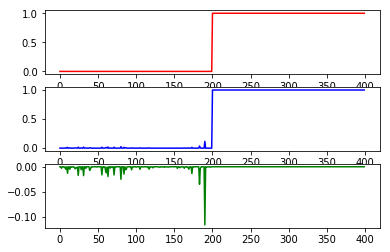

In [27]:
plt.subplot(3, 1, 1)
plt.plot(Y_test[:, 1], 'r')

plt.subplot(3, 1, 2)
plt.plot(Y_pred[:, 1], 'b')

plt.subplot(3, 1, 3)
plt.plot(Y_test[:, 1] - Y_pred[:, 1], 'g')

plt.show()

In [28]:
# : is not allowed in file name in windows OS
now = datetime.datetime.now()

modelSaved = '{}-{}_{}_{}.h5'.format(folderNormal, folderFault, pretrainedModel, now.strftime('%m-%d-%H-%M-%S'))
meanSaved = 'mean_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))
stdSaved = 'std_{}.npy'.format(now.strftime('%m-%d-%H-%M-%S'))

inputStr = input('''Save Model as '{}'? (y/n)\n'''.format(modelSaved))

if (inputStr == 'y' or inputStr == 'Y'):  
    
    np.save(modelPath + '/' + meanSaved, trainMean)
    np.save(modelPath + '/' + stdSaved, trainStd)
    model.save(modelPath + '/' + modelSaved)



Save Model as 'A3F1P3-A3F5P3_ResNet50_10-14-14-48-59.h5'? (y/n)
y
